# Compare background subtracted SSPALS traces (looped data)

<span style="color:red">IMPORTANT</span> - This notebook reads HDF5 files. Always PAUSE Sequencer.vi to run analysis for current sequence (HDF5 r/w conflict)!

In [1]:
#import python packages
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
%matplotlib inline
import oskar, sspals

### Import

In [3]:
rid = '20160424_115511'
h5 = oskar.H5Data(rid)             # data
h5.load_log()
vDF = h5.var_df()
uDF = h5.unique_df()
out_dire = h5.out_dire("Traces")    # output
h5.pprint()

20160424_115511
   Author:	 AA,BC
   Description:  Pulser delay scan, lineshapes at each delay
		 (pulser) DLY_GA: 1.05u, 1.4u, 10u
		 (lasers) DLY_EA: 635ns
		 IR: 755.63 - 761.81 (0.06)nm
		 T = 2.2kV
		 G = 200 V
		 Initial temp: 97.1deg 


In [4]:
uDF.head()

,DLY_EA,DLY_GA,IR,VOL_u101,VOL_u104
VID,,,,,
1,6.350000e-07,0.000001,755.63,200,2200
2,6.350000e-07,0.000001,755.69,200,2200
3,6.350000e-07,0.000001,755.75,200,2200
4,6.350000e-07,0.000001,755.81,200,2200
5,6.350000e-07,0.000001,755.87,200,2200


In [10]:
uDF[uDF.IR == 757.55]

,DLY_EA,DLY_GA,IR,VOL_u101,VOL_u104
VID,,,,,
33,6.350000e-07,0.000001,757.55,200,2200
137,6.350000e-07,0.000001,757.55,200,2200
241,6.350000e-07,0.000010,757.55,200,2200


In [24]:
VIDS = np.array([1, 137]) # import data
chan_hi = 'CH_L2'
chan_low = 'CH_L3'
# params
limits = [-1e-8, 1.7e-7, 6.5e-7]
dtype=[('t0','float'),('AC','float'),('BC','float'),('DF','float')]
# get data
DF = pd.DataFrame(np.array([],dtype=dtype))
data = dict()
max_num = 100  # maximum number of squids to include
for vid in tqdm(VIDS):
    squids = vDF[(vDF == uDF.loc[vid]).all(1)].index.values[:max_num]
    hi, osc_hi = h5.load_array(squids, chan_hi)
    low, osc_low = h5.load_array(squids, chan_low)
    dt = osc_hi['dt']
    chmx = sspals.chmx(hi, low, invert=True, n_bsub=100,
                       validate=True, min_range=0.1)
    # sspals
    DF = sspals.sspals(chmx, dt, limits=limits)
    x = (np.arange(np.shape(chmx)[1])*dt) - DF.t0.mean()
    data[vid] = {'x':x, 'y':chmx, 'DF':DF}

In [19]:
pvids = [137]  # plot these vids
bvids = [1]   # with these backgrounds

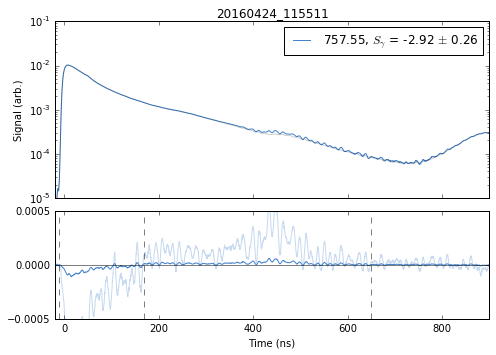

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

# plot setup
fig, ax = plt.subplots(figsize=(7,5))

# background subtraction subplot
divider = make_axes_locatable(ax)
axx = divider.append_axes("bottom", size=1.5, pad=0.18, sharex=ax)

# plot traces
for i, vid in enumerate(pvids):
    bvid = bvids[i]
    x = 1e9 * data[vid]['x']
    norm = np.divide(data[vid]['y'].T, 1e9 * data[vid]['DF'].AC.values).T
    y1 = np.mean(norm, 0)
    bnorm = np.divide(data[bvid]['y'].T, 1e9 * data[bvid]['DF'].AC.values).T
    b1 = np.mean(bnorm, 0)
    reps = len(data[vid]['DF'].index)
    breps = len(data[bvid]['DF'].index)
    sig = sspals.signal(data[vid]['DF'].DF.mean(), data[vid]['DF'].DF.std() / np.sqrt(reps),
              data[bvid]['DF'].DF.mean(), data[bvid]['DF'].DF.std() / np.sqrt(breps))
    ax.plot(x, y1, c=oskar.colors[i], label=str(uDF.loc[vid, 'IR']) + r', $S_\gamma$ = %.2f $\pm$ %.2f'%sig)
    ax.plot(x, b1, c='k', alpha=0.2)
    axx.plot(x, (y1 - b1), c=oskar.colors[i])
    axx.plot(x, 10*(y1 - b1), c=oskar.colors[i], alpha=0.3)
    
ax.set_ylim(1e-5, 1e-1)
ax.set_yscale('log')
axx.set_ylim(-0.0005, 0.0005)
#axx.set_yticks([-0.01, 0, 0.01])
plt.locator_params(nbins=3, axis='y')

#format
ax.set_xlim(-20, 900)
ax.set_ylabel("Signal (arb.)");
lgd = ax.legend(loc=1)
plt.setp(ax.get_xticklabels(), visible=False)
axx.set_xlabel(r"Time (ns)");
plt.axhline(0, color='k', alpha=0.5)
for lim in limits:
    plt.axvline(lim * 1e9, ls='--', c='k', alpha=0.5)
ax.set_title(rid)

#save data
plt.tight_layout();
fileout = os.path.join(out_dire, "bsub_pwo.png")
plt.savefig(fileout, dpi=300)
plt.show()